In [2]:
# !pip install pandas numpy matplotlib scikit-learn imbalanced-learn seaborn

In [1]:
import pandas as pd
import numpy as np

import gcsfs
import json

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, RepeatedKFold
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_curve, roc_auc_score, auc, accuracy_score, confusion_matrix, classification_report

from imblearn.over_sampling import SMOTE

#### Load credentials for google-cloud

In [2]:
!gsutil ls gs://lavoz-datascience/tmp

gs://lavoz-datascience/tmp/
gs://lavoz-datascience/tmp/Untitled.ipynb
gs://lavoz-datascience/tmp/conversiones.csv
gs://lavoz-datascience/tmp/device_data.csv
gs://lavoz-datascience/tmp/df_full_encoded.csv
gs://lavoz-datascience/tmp/df_pw_joined.csv
gs://lavoz-datascience/tmp/gcp.json
gs://lavoz-datascience/tmp/local.ipynb
gs://lavoz-datascience/tmp/pageviews.csv
gs://lavoz-datascience/tmp/pageviews_complemento.csv
gs://lavoz-datascience/tmp/.ipynb_checkpoints/


In [3]:
!gsutil cat gs://lavoz-datascience/tmp/gcp.json > gcp.json && ls

bin	  home		  media				    root  usr
boot	  initrd.img	  miniconda			    run   var
dev	  initrd.img.old  Miniconda3-4.5.4-Linux-x86_64.sh  sbin  vmlinuz
etc	  lib		  mnt				    srv   vmlinuz.old
gcp.json  lib64		  opt				    sys
hadoop	  lost+found	  proc				    tmp


In [2]:
token = json.load(open('gcp.json'))
fs = gcsfs.GCSFileSystem(project='gc-la-voz',token=token)

---

### Load data and exploration

In [ ]:
df_pw = pd.concat([pd.read_csv(fs.open('gs://lavoz-datascience/tmp/pageviews.csv'), parse_dates=["FEC_EVENT"]),
                   pd.read_csv(fs.open('gs://lavoz-datascience/tmp/pageviews_complemento.csv'), parse_dates=["FEC_EVENT"])
                  ], sort=False)
df_pw.shape

In [ ]:
df_pw.head()

In [ ]:
df_pw['mes_event']= df_pw.FEC_EVENT.dt.month
# df_pw['anio']= df_pw.FEC_EVENT.dt.year

In [ ]:
# Values for column
for col in df_pw.columns.to_list():
    print(col, len(df_pw[col].value_counts()))

In [7]:
# Stats for columns
for col in df_pw.drop(columns=['USER_ID', 'FEC_EVENT', 'mes_event']).columns.to_list():
    print(df_pw[col].describe(), end=f'\n{"-"*88}\n')

count    1.409043e+07
mean     6.158803e+01
std      1.375727e+02
min      1.000000e+00
25%      3.000000e+00
50%      2.100000e+01
75%      5.900000e+01
max      1.833000e+03
Name: PAGE, dtype: float64
----------------------------------------------------------------------------------------
count    1.409043e+07
mean     2.363839e+00
std      1.972155e+00
min      1.000000e+00
25%      2.000000e+00
50%      2.000000e+00
75%      2.000000e+00
max      6.800000e+01
Name: CONTENT_CATEGORY, dtype: float64
----------------------------------------------------------------------------------------
count    1.409043e+07
mean     1.984583e+00
std      4.631534e-01
min      1.000000e+00
25%      2.000000e+00
50%      2.000000e+00
75%      2.000000e+00
max      1.300000e+01
Name: CONTENT_CATEGORY_TOP, dtype: float64
----------------------------------------------------------------------------------------
count    1.409043e+07
mean     2.363839e+00
std      1.972155e+00
min      1.000000e+00
25%     

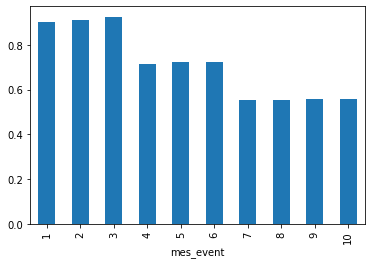

In [8]:
# events for month
(df_pw.groupby(['mes_event']).USER_ID.nunique() /
df_pw.USER_ID.nunique()).plot(kind="bar")
plt.show()

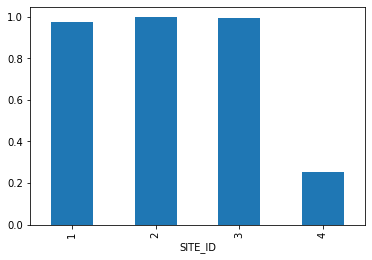

In [14]:
# Events for site
(df_pw.groupby(['SITE_ID']).USER_ID.nunique() /
df_pw.USER_ID.nunique()).plot(kind="bar")
plt.show()

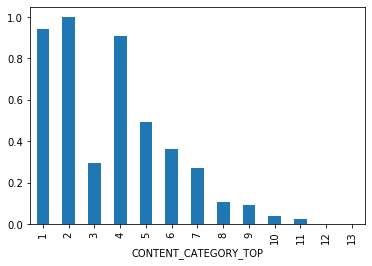

In [15]:
# Events for CONTENT_CATEGORY_TOP
(df_pw.groupby(['CONTENT_CATEGORY_TOP']).USER_ID.nunique() /
df_pw.USER_ID.nunique()).plot(kind="bar")
plt.show()

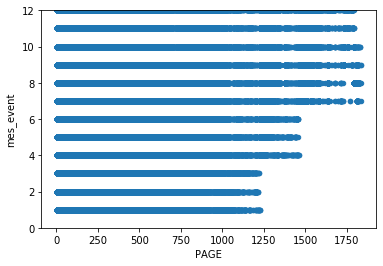

In [24]:
var = 'PAGE'
data = pd.concat([df_pw['mes_event'], df_pw[var]], axis=1)
data.plot.scatter(x=var, y='mes_event', ylim=(0,12));

In [16]:
# missing data
total = df_pw.isnull().sum().sort_values(ascending=False)
percent = (df_pw.isnull().sum()/df_pw.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
mes_event,0,0.0
USER_ID,0,0.0
ON_SITE_SEARCH_TERM,0,0.0
SITE_ID,0,0.0
CONTENT_CATEGORY_BOTTOM,0,0.0
CONTENT_CATEGORY_TOP,0,0.0
CONTENT_CATEGORY,0,0.0
PAGE,0,0.0
FEC_EVENT,0,0.0


In [22]:
# standardizing data
saleprice_scaled = StandardScaler().fit_transform(df_pw['PAGE'][:,np.newaxis]);
low_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][:10]
high_range= saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-0.39544109]
 [-0.39544109]
 [-0.39544109]
 [-0.39544109]
 [-0.39544109]
 [-0.39544109]
 [-0.39544109]
 [-0.39544109]
 [-0.39544109]
 [-0.39544109]]

outer range (high) of the distribution:
[[10.30539931]
 [10.31125957]
 [10.31711983]
 [10.3229801 ]
 [10.32884036]
 [10.33470062]
 [10.34056089]
 [10.34056089]
 [10.34642115]
 [10.35228141]]


### Separamos en Tests y Train calculando media de cada variable

In [ ]:
# Create X_test with whole period and group events for USER_ID
X_test = []
for c in df_pw.drop(['USER_ID', 'FEC_EVENT', 'mes_event'], axis=1).columns:
    print('haciendo', c)
    temp = pd.crosstab(df_pw.USER_ID, df_pw[c])
    temp.columns = [c + "_" + str(v) for v in temp.columns]
    X_test.append(temp.apply(lambda x: x / x.sum(), axis=1))

X_test = pd.concat(X_test, axis=1)

In [ ]:
# Create X_train with 'mes < 10' period and group events for USER_ID
X_train = []
for c in df_pw[df_pw.mes_event < 10].drop(['USER_ID', 'FEC_EVENT', 'mes_event'], axis=1).columns:
    print('haciendo', c)
    temp = pd.crosstab(df_pw[df_pw.mes_event < 10].USER_ID, df_pw[df_pw.mes_event < 10][c])
    temp.columns = [c + "_" + str(v) for v in temp.columns]
    X_train.append(temp.apply(lambda x: x / x.sum(), axis=1))

X_train = pd.concat(X_train, axis=1)

In [11]:
X_train.head()

,PAGE_1,PAGE_2,PAGE_3,PAGE_4,PAGE_5,PAGE_6,PAGE_7,PAGE_8,PAGE_9,PAGE_10,...,ON_SITE_SEARCH_TERM_284.0,ON_SITE_SEARCH_TERM_285.0,ON_SITE_SEARCH_TERM_286.0,ON_SITE_SEARCH_TERM_287.0,ON_SITE_SEARCH_TERM_288.0,ON_SITE_SEARCH_TERM_289.0,ON_SITE_SEARCH_TERM_290.0,ON_SITE_SEARCH_TERM_291.0,ON_SITE_SEARCH_TERM_292.0,ON_SITE_SEARCH_TERM_293.0
USER_ID,,,,,,,,,,,,,,,,,,,,,
0.0,0.049499,0.090226,0.022556,0.007832,0.001880,0.004699,0.000313,0.000313,0.067043,0.176065,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.0,0.120096,0.120897,0.016813,0.007206,0.001601,0.000801,0.000000,0.000000,0.075260,0.184147,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2.0,0.031083,0.168274,0.078242,0.013934,0.018221,0.001072,0.000000,0.000000,0.063237,0.130761,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3.0,0.000000,0.169557,0.108863,0.032755,0.030829,0.006744,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4.0,0.014530,0.092891,0.076803,0.002076,0.028023,0.024390,0.000000,0.000519,0.001557,0.243902,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
X_train.shape, X_test.shape 

((11444, 1982), (11492, 2016))

In [ ]:
# Get features
features = list(set(X_train.columns).intersection(set(X_test.columns)))
X_train = X_train[features]
X_test = X_test[features]

In [ ]:
df_tag = pd.read_csv(fs.open('gs://lavoz-datascience/tmp/conversiones.csv'))

In [19]:
# df_pw = df_pw.join(df_tag)

In [ ]:
idx = df_pw.USER_ID.unique()
y_test = pd.Series(0, index=idx)
y_test[y_test.index.isin(df_tag.USER_ID.unique())] = 1

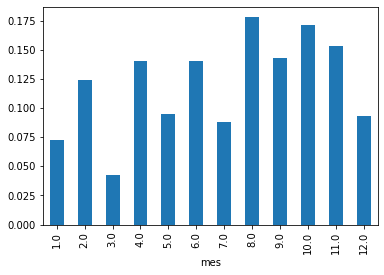

In [17]:
# convertions for month
(df_tag.groupby(['mes']).USER_ID.nunique() /
df_tag.USER_ID.nunique()).plot(kind="bar")
plt.show()

In [ ]:
df_pw.loc[df_pw.USER_ID.isin(df_tag.USER_ID), 'tag'] = 1
df_pw.tag.fillna(0, inplace=True)

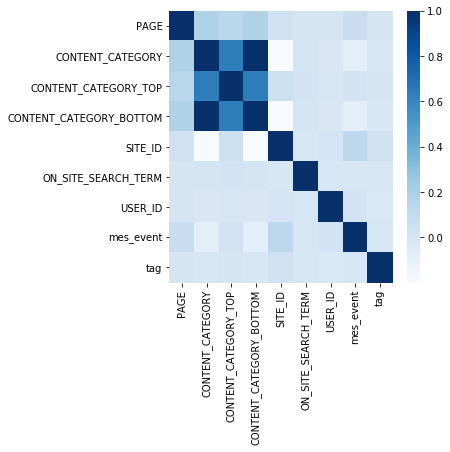

In [29]:
# columns correlation
corr = df_pw.corr()
plt.figure(figsize=(5,5))
_ = sns.heatmap(corr, cmap='Blues')

In [ ]:
# Create y_train
y_train = pd.Series(0, index=X_train.index)
idx = set(df_tag[df_tag.mes >= 10].USER_ID.unique()).intersection(set(X_train.index))
y_train.loc[list(idx)] = 1

### Training Logistic Regression

In [33]:
# selector = SelectPercentile(chi2, percentile=50)
scaler = StandardScaler()
logreg = LogisticRegression(penalty='l2', C=0.0001, class_weight='balanced', random_state=0, max_iter=1000, n_jobs=-2)

lr_pl = make_pipeline(scaler, logreg)

In [77]:
hiperparams_lr= {
#     'logisticregression__C': np.linspace(0.0001, 0.00025, 10),
    'logisticregression__solver': ['lbfgs', 'liblinear'], #['newton-cg','sag','lbfgs'],
    #'logisticregression__class_weight': ['balanced', 'auto'],
    #'selectpercentile__percentile': [50], # range(10, 100, 30),
}

lr_grid = GridSearchCV(lr_pl, hiperparams_lr, scoring='roc_auc', cv=25, n_jobs=-2)

In [78]:
%time lr_grid.fit(X_train, y_train)

/home/who/Enviroments/lavoz-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


CPU times: user 45.6 s, sys: 467 ms, total: 46 s
Wall time: 13min 14s


GridSearchCV(cv=25, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('logisticregression',
                                        LogisticRegression(C=1.0,
                                                           class_weight='balanced',
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=1000,
                                             

In [79]:
lr_grid.best_estimator_

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=1000,
                                    multi_class='warn', n_jobs=-2, penalty='l2',
                                    random_state=0, solver='liblinear',
                                    tol=0.0001, verbose=0, warm_start=False))],
         verbose=False)

In [80]:
sum(y_test), sum(lr_grid.predict(X_test))

(1083, 1409)

In [74]:
idx = list(set(y_test.index).intersection(set(X_test.index)))

In [75]:
y_test = y_test[y_test.index.isin(idx)]

In [81]:
print(classification_report(y_test, lr_grid.predict(X_test)))

              precision    recall  f1-score   support

           0       0.95      0.92      0.93     10409
           1       0.38      0.49      0.43      1083

    accuracy                           0.88     11492
   macro avg       0.66      0.71      0.68     11492
weighted avg       0.89      0.88      0.88     11492



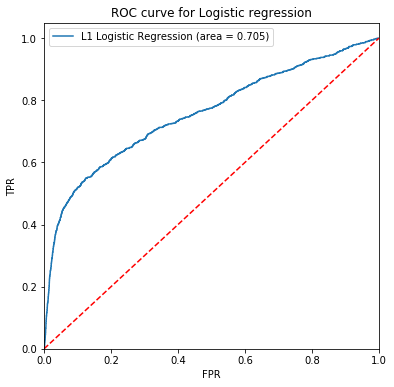

In [82]:
roc_auc = roc_auc_score(y_test, lr_grid.predict(X_test))
#Obtaining false and true positives & thresholds
fpr, tpr, thresholds = roc_curve(y_test, lr_grid.predict_proba(X_test)[:,1])
#Plotting the curve
fig = plt.figure(figsize=(6, 6))

plt.plot(fpr, tpr, label='L1 Logistic Regression (area = %0.03f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve for Logistic regression')
plt.legend(loc="upper left")

### Training Random Forest

In [ ]:
# selector = SelectPercentile(chi2, percentile=50)
rf = RandomForestClassifier(criterion='entropy', class_weight='balanced', random_state=0, n_jobs=-2)

rf_pl = make_pipeline(scaler, rf)

In [ ]:
hiperparams_rf = {
    'randomforestclassifier__n_estimators': [10000, 20000, 50000],
#     'randomforestclassifier__class_weight': ['balanced', 'balanced_subsample']
#     'randomforestclassifier__min_samples_split': [10],
    #     'randomforestclassifier__criterion': ['gini', 'entropy'],
}

rf_grid = GridSearchCV(rf_pl, hiperparams_rf, scoring='roc_auc', cv=5, n_jobs=-2)

In [ ]:
%time rf_grid.fit(X_train, y_train)

In [ ]:
rf_grid.best_estimator_

In [ ]:
sum(y_test), sum(rf_grid.predict(X_test))

In [ ]:
print(classification_report(y_test, rf_grid.predict(X_test)))

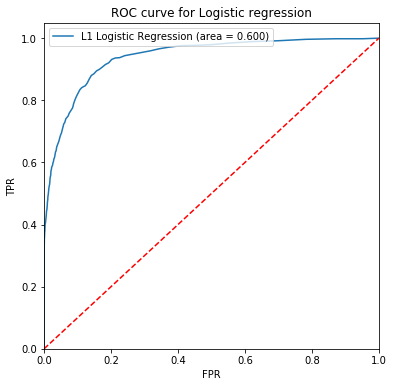

In [90]:
roc_auc = roc_auc_score(y_test, rf_grid.predict(X_test))
#Obtaining false and true positives & thresholds
fpr, tpr, thresholds = roc_curve(y_test, rf_grid.predict_proba(X_test)[:,1])
#Plotting the curve
fig = plt.figure(figsize=(6, 6))

plt.plot(fpr, tpr, label='L1 Logistic Regression (area = %0.03f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve for Logistic regression')
plt.legend(loc="upper left")

In [ ]:
# Entrenamos el modelo LGBM Classifier
from lightgbm import LGBMClassifier

# importancia de las variables de los modelos entrenados
fi = []
# probabilidades estimadas
test_probs = []
i = 0 
# Iterams sobre 10 folds
for train_idx, valid_idx in KFold(n_splits=10, shuffle=True).split(X_train):
    i += 1
    # train set
    Xt = X_train.iloc[train_idx]
    yt = y_train.iloc[train_idx] # y_train.loc[X_train.index].iloc[train_idx]

    # validation set
    Xv = X_train.iloc[valid_idx]
    yv = y_train.iloc[valid_idx]

    learner = LGBMClassifier(n_estimators=10000)
    # Definimos un early stop de 10 y el método de evaluación como AUC
    learner.fit(Xt, yt,  early_stopping_rounds=10, eval_metric="auc", eval_set=[(Xt, yt), (Xv, yv)])
    
    # Predecimos sobre la base total y nos guardamos las probabilidades estimadas
    test_probs.append(pd.Series(learner.predict_proba(X_test)[:, -1],
                                index=X_test.index,
                                name="fold_" + str(i)))
     # Guardamos la proporción de importancia de cada variable en el modelo
    fi.append(pd.Series(learner.feature_importances_ / learner.feature_importances_.sum(), index=Xt.columns))

 # Caluclamos la media de las probabilidades
test_probs = pd.concat(test_probs, axis=1).mean(axis=1)
test_probs.index.name="USER_ID" # Renombramos las columnas
test_probs.name="SCORE" # Renombramos las columnas

# Guardamos la predicción final en un zip para subirlo a la plataforma
# test_probs.to_csv("benchmark.zip", header=True, compression="zip")

# Como explicación del modelo guardamos la importancia de las variables de los modelos entrenados
fi = pd.concat(fi, axis=1).mean(axis=1)